# Verification Effects Visualization

This notebook visualizes the effects of suppressing or amplifying bias features.

**Purpose:**
- Verify that identified bias features actually cause bias predictions
- Compare suppression vs. amplification vs. random control
- Quantify effect sizes across demographics

**Input Data:**
- Verification results (baseline, suppress, amplify, random)
- Logit gaps before and after manipulation

**Output:**
- 3×3 grid of bar charts showing effects per demographic
- Effect size summary statistics
- Statistical significance tests

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

PROJECT_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJECT_ROOT))

from src.visualization import (
    setup_korean_font,
    load_demographics,
    load_verification_results,
    plot_verification_effects,
    get_demographic_labels
)

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier


In [2]:
# Setup
setup_korean_font()
sns.set_style('whitegrid')

Font configured: ['Noto Sans CJK KR']


In [3]:
# Configuration
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage: 'pilot', 'medium', or 'full'
STAGE = "pilot"

# SAE configuration (for reference)
SAE_TYPE = "gated"  # 'standard' or 'gated'
LAYER_QUANTILE = "q2"  # 'q1', 'q2', or 'q3'

# Demographic to analyze (None = analyze all)
DEMOGRAPHIC = None  # e.g., "성별", "인종", etc.

print(f"Stage: {STAGE}")
print(f"SAE type: {SAE_TYPE}")
print(f"Layer quantile: {LAYER_QUANTILE}")
print(f"Demographic: {DEMOGRAPHIC or 'all'}")

Stage: pilot
SAE type: gated
Layer quantile: q2
Demographic: all


## Load Data

In [4]:
# Load demographics
demographics_dict = load_demographics(DATA_DIR)
demographic_labels_ko, demographic_labels_en = get_demographic_labels(demographics_dict)

# Load verification results (loads from all per-demographic directories)
verification_results = load_verification_results(RESULTS_DIR, stage=STAGE, demographic=DEMOGRAPHIC)

print(f"Loaded verification results for {len(verification_results)} demographics")
for demo in verification_results.keys():
    print(f"  - {demo}")

Loaded verification results for 9 demographics
  - 외모
  - 성적지향
  - 정치성향
  - 직업
  - 종교
  - 경제수준
  - 성별
  - 인종
  - 나이


## Plot Verification Effects

/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:332: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:332: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:332: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:332: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:332: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src

Saved to /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets/verification_effects_pilot.png


/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/

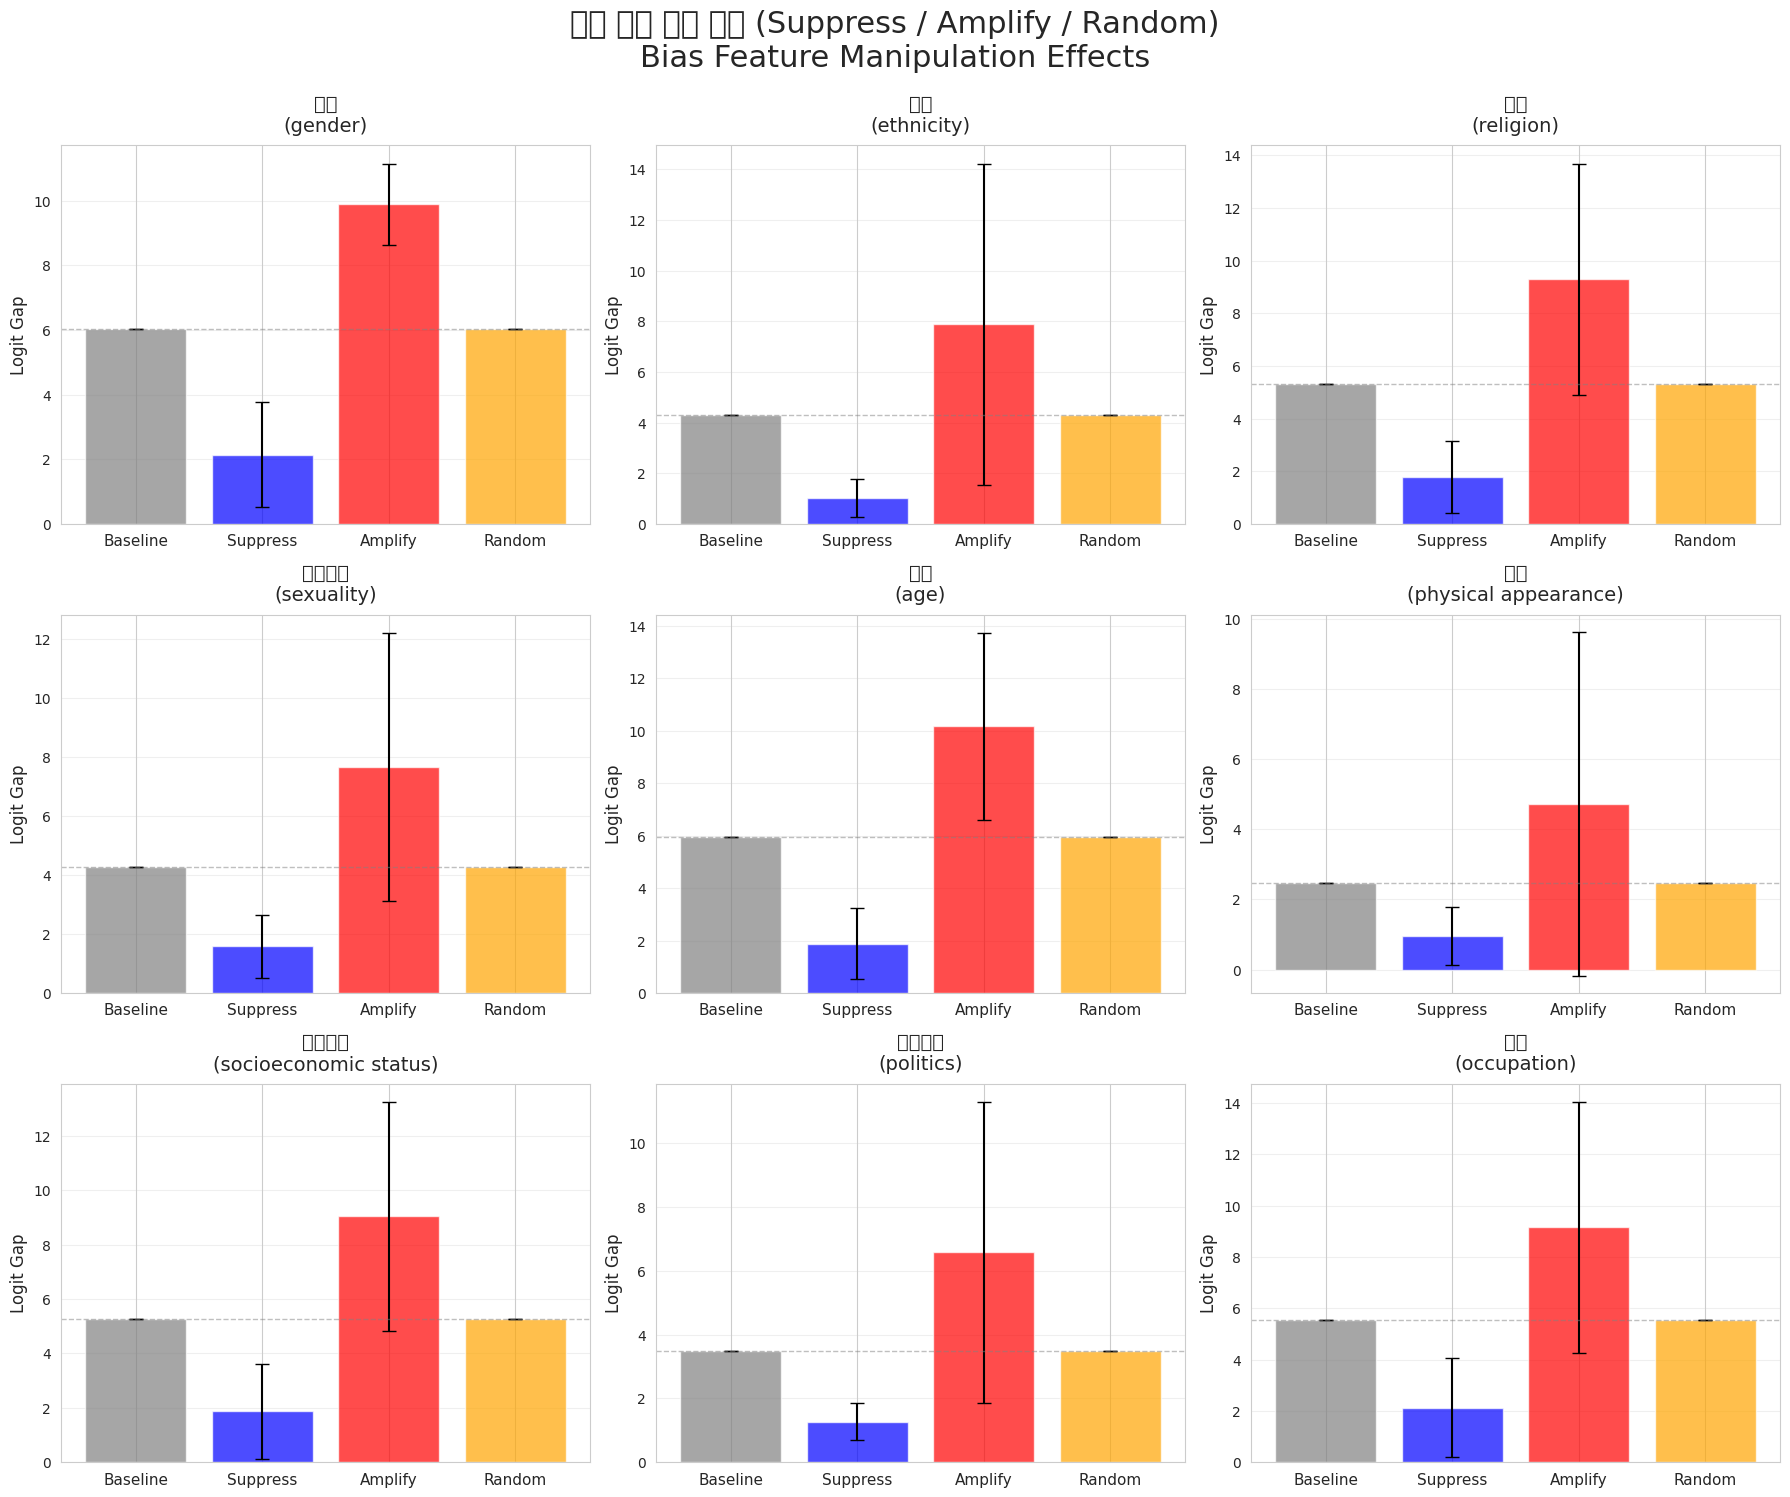

In [5]:
fig = plot_verification_effects(
    verification_results=verification_results,
    demographic_labels_ko=demographic_labels_ko,
    demographic_labels_en=demographic_labels_en,
    save_path=ASSETS_DIR / f"verification_effects_{STAGE}.png",
    figsize=(18, 15)
)

plt.show()

## Effect Size Analysis

In [6]:
# Compute effect sizes
effect_sizes = []

for demo_ko in demographic_labels_ko:
    if demo_ko not in verification_results:
        continue
    
    results = verification_results[demo_ko]
    baseline = results.get('baseline_gap_mean', 0)
    
    if baseline > 0:
        suppress_effect = (results.get('suppress_gap_mean', 0) - baseline) / baseline
        amplify_effect = (results.get('amplify_gap_mean', 0) - baseline) / baseline
        random_effect = (results.get('random_gap_mean', 0) - baseline) / baseline
    else:
        suppress_effect = 0
        amplify_effect = 0
        random_effect = 0
    
    effect_sizes.append({
        'Demographic': demo_ko,
        'Baseline Gap': baseline,
        'Suppress Effect (%)': suppress_effect * 100,
        'Amplify Effect (%)': amplify_effect * 100,
        'Random Effect (%)': random_effect * 100,
        'Suppress Std': results.get('suppress_gap_std', 0),
        'Amplify Std': results.get('amplify_gap_std', 0),
    })

df_effects = pd.DataFrame(effect_sizes)

print("\nVerification Effect Sizes:")
print("=" * 100)
print(df_effects.to_string(index=False))

# Save to CSV
df_effects.to_csv(ASSETS_DIR / f"verification_effect_sizes_{STAGE}.csv", index=False)
print(f"\nSaved to {ASSETS_DIR / f'verification_effect_sizes_{STAGE}.csv'}")


Verification Effect Sizes:
Demographic  Baseline Gap  Suppress Effect (%)  Amplify Effect (%)  Random Effect (%)  Suppress Std  Amplify Std
         성별      6.016926           -64.347990           64.347978                0.0      1.633175     1.257559
         인종      4.318915           -76.119375           82.701213                0.0      0.747662     6.344100
         종교      5.323876           -66.227779           74.447975                0.0      1.371690     4.400861
       성적지향      4.291003           -62.830215           78.781493                0.0      1.066567     4.546984
         나이      5.948673           -68.278443           71.046224                0.0      1.355669     3.569082
         외모      2.471632           -61.214256           90.976886                0.0      0.820820     4.901520
       경제수준      5.270569           -64.550876           71.443652                0.0      1.752155     4.211788
       정치성향      3.479509           -63.612449           88.956785  

## Comparative Analysis

/tmp/ipykernel_26373/2033357071.py:35: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_26373/2033357071.py:35: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_26373/2033357071.py:35: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_26373/2033357071.py:35: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_26373/2033357071.py:35: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_26373/2033357071.py:35: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_26373/2033357071.py:35: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  

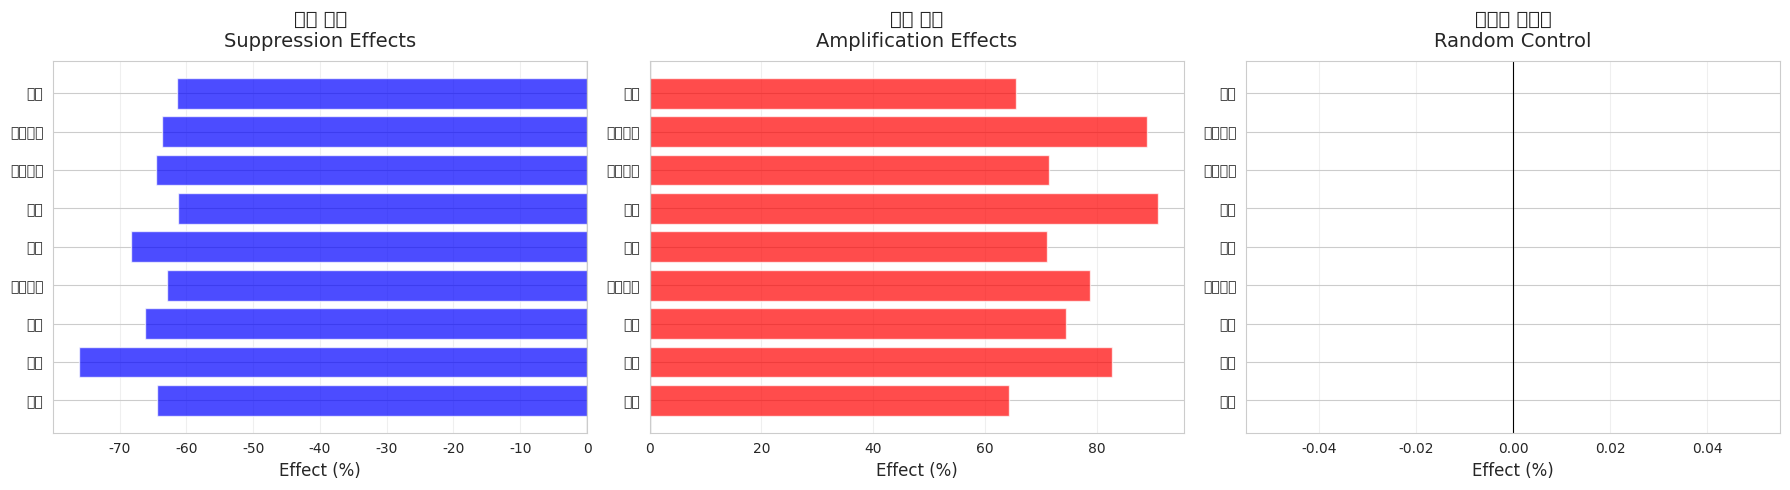

In [7]:
# Compare effect sizes across demographics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Suppress effects
ax = axes[0]
x = np.arange(len(df_effects))
ax.barh(x, df_effects['Suppress Effect (%)'], color='blue', alpha=0.7)
ax.set_yticks(x)
ax.set_yticklabels(df_effects['Demographic'])
ax.set_xlabel('Effect (%)', fontsize=12)
ax.set_title('억제 효과\nSuppression Effects', fontsize=14, pad=10)
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Amplify effects
ax = axes[1]
ax.barh(x, df_effects['Amplify Effect (%)'], color='red', alpha=0.7)
ax.set_yticks(x)
ax.set_yticklabels(df_effects['Demographic'])
ax.set_xlabel('Effect (%)', fontsize=12)
ax.set_title('증폭 효과\nAmplification Effects', fontsize=14, pad=10)
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Random effects (should be near zero)
ax = axes[2]
ax.barh(x, df_effects['Random Effect (%)'], color='orange', alpha=0.7)
ax.set_yticks(x)
ax.set_yticklabels(df_effects['Demographic'])
ax.set_xlabel('Effect (%)', fontsize=12)
ax.set_title('무작위 대조군\nRandom Control', fontsize=14, pad=10)
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(ASSETS_DIR / f"effect_sizes_comparison_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

## Success Criteria Evaluation

In [8]:
# Evaluation criteria:
# - Suppress should reduce gap by >5%
# - Amplify should increase gap by >5%
# - Random should have <5% effect

THRESHOLD = 5.0  # percent

success_counts = {
    'suppress_success': 0,
    'amplify_success': 0,
    'random_minimal': 0,
    'total': len(df_effects)
}

print("\nSuccess Criteria Evaluation:")
print("=" * 100)
print(f"Threshold: ±{THRESHOLD}%\n")

for _, row in df_effects.iterrows():
    demo = row['Demographic']
    suppress = row['Suppress Effect (%)']
    amplify = row['Amplify Effect (%)']
    random = row['Random Effect (%)']
    
    suppress_ok = suppress < -THRESHOLD
    amplify_ok = amplify > THRESHOLD
    random_ok = abs(random) < THRESHOLD
    
    if suppress_ok:
        success_counts['suppress_success'] += 1
    if amplify_ok:
        success_counts['amplify_success'] += 1
    if random_ok:
        success_counts['random_minimal'] += 1
    
    status = '✓' if (suppress_ok and amplify_ok and random_ok) else '✗'
    print(f"{status} {demo:15s} | Suppress: {suppress:+6.1f}% {'✓' if suppress_ok else '✗'} | "
          f"Amplify: {amplify:+6.1f}% {'✓' if amplify_ok else '✗'} | "
          f"Random: {random:+6.1f}% {'✓' if random_ok else '✗'}")

print("\n" + "=" * 100)
print(f"\nOverall Success Rates:")
print(f"  Suppress success: {success_counts['suppress_success']}/{success_counts['total']} "
      f"({success_counts['suppress_success']/success_counts['total']*100:.1f}%)")
print(f"  Amplify success:  {success_counts['amplify_success']}/{success_counts['total']} "
      f"({success_counts['amplify_success']/success_counts['total']*100:.1f}%)")
print(f"  Random minimal:   {success_counts['random_minimal']}/{success_counts['total']} "
      f"({success_counts['random_minimal']/success_counts['total']*100:.1f}%)")


Success Criteria Evaluation:
Threshold: ±5.0%

✓ 성별              | Suppress:  -64.3% ✓ | Amplify:  +64.3% ✓ | Random:   +0.0% ✓
✓ 인종              | Suppress:  -76.1% ✓ | Amplify:  +82.7% ✓ | Random:   +0.0% ✓
✓ 종교              | Suppress:  -66.2% ✓ | Amplify:  +74.4% ✓ | Random:   +0.0% ✓
✓ 성적지향            | Suppress:  -62.8% ✓ | Amplify:  +78.8% ✓ | Random:   +0.0% ✓
✓ 나이              | Suppress:  -68.3% ✓ | Amplify:  +71.0% ✓ | Random:   +0.0% ✓
✓ 외모              | Suppress:  -61.2% ✓ | Amplify:  +91.0% ✓ | Random:   +0.0% ✓
✓ 경제수준            | Suppress:  -64.6% ✓ | Amplify:  +71.4% ✓ | Random:   +0.0% ✓
✓ 정치성향            | Suppress:  -63.6% ✓ | Amplify:  +89.0% ✓ | Random:   +0.0% ✓
✓ 직업              | Suppress:  -61.5% ✓ | Amplify:  +65.5% ✓ | Random:   +0.0% ✓


Overall Success Rates:
  Suppress success: 9/9 (100.0%)
  Amplify success:  9/9 (100.0%)
  Random minimal:   9/9 (100.0%)


## Statistical Summary

In [9]:
# Summary statistics
print("\nEffect Size Statistics:")
print("=" * 80)

for effect_type in ['Suppress Effect (%)', 'Amplify Effect (%)', 'Random Effect (%)']:
    values = df_effects[effect_type]
    print(f"\n{effect_type}:")
    print(f"  Mean:   {values.mean():+7.2f}%")
    print(f"  Median: {values.median():+7.2f}%")
    print(f"  Std:    {values.std():7.2f}%")
    print(f"  Min:    {values.min():+7.2f}%")
    print(f"  Max:    {values.max():+7.2f}%")


Effect Size Statistics:

Suppress Effect (%):
  Mean:    -65.41%
  Median:  -64.35%
  Std:       4.59%
  Min:     -76.12%
  Max:     -61.21%

Amplify Effect (%):
  Mean:    +76.47%
  Median:  +74.45%
  Std:       9.59%
  Min:     +64.35%
  Max:     +90.98%

Random Effect (%):
  Mean:     +0.00%
  Median:   +0.00%
  Std:       0.00%
  Min:      +0.00%
  Max:      +0.00%


## Interpretation

### Expected Results:

1. **Suppression (Blue bars):**
   - Should show negative effect (decrease in logit gap)
   - Target: >5% reduction
   - Indicates features contribute to bias

2. **Amplification (Red bars):**
   - Should show positive effect (increase in logit gap)
   - Target: >5% increase
   - Confirms features are causal for bias

3. **Random Control (Orange bars):**
   - Should be near zero (<5% change)
   - Validates specificity of identified features
   - Rules out non-specific effects

### What to Look For:

- **Strong Effects:** Which demographics show largest suppression/amplification?
- **Asymmetry:** Are suppress/amplify effects symmetric?
- **Controls:** Are random effects truly minimal?
- **Consistency:** Do effects align with IG² scores?

### Next Steps:

1. Investigate demographics with weak effects
2. Test different feature thresholds
3. Examine individual feature contributions
4. Correlate with real-world bias metrics